## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

device

'cuda:0'

In [29]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [30]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [31]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [155]:
len(fmnist_dataset_train), len(fmnist_dataset_test)

(60000, 10000)

In [33]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [153]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 2*num_classes),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2*num_classes),
            nn.Linear(2*num_classes, num_classes),
            nn.Tanh(),
            nn.BatchNorm1d(num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

    def __call__(self, inp):
        return self.forward(inp)

In [154]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 20]          15,700
         LeakyReLU-3                   [-1, 20]               0
       BatchNorm1d-4                   [-1, 20]              40
            Linear-5                   [-1, 10]             210
              Tanh-6                   [-1, 10]               0
       BatchNorm1d-7                   [-1, 10]              20
Total params: 15,970
Trainable params: 15,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


Your experiments come here:

In [115]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = loss_fn(out, y_batch)
                
                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum((y_pred.cpu() == y_batch.cpu()).numpy())/len(y_batch.cpu().numpy()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [116]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

n_epochs = 10
train_loss, val_loss, val_accuracy = train_model(model, train_loader,
                                                 test_loader, loss_func,
                                                 opt, n_epochs)

Epoch 1 of 10 took 6.142s
	  training loss: 0.738484
	validation loss: 0.591844
	validation accuracy: 0.835
Epoch 2 of 10 took 6.058s
	  training loss: 0.510190
	validation loss: 0.488715
	validation accuracy: 0.846
Epoch 3 of 10 took 6.146s
	  training loss: 0.446696
	validation loss: 0.474769
	validation accuracy: 0.841
Epoch 4 of 10 took 6.163s
	  training loss: 0.419466
	validation loss: 0.454599
	validation accuracy: 0.847
Epoch 5 of 10 took 6.323s
	  training loss: 0.397236
	validation loss: 0.459950
	validation accuracy: 0.842
Epoch 6 of 10 took 6.117s
	  training loss: 0.382861
	validation loss: 0.419077
	validation accuracy: 0.853
Epoch 7 of 10 took 6.118s
	  training loss: 0.370051
	validation loss: 0.415660
	validation accuracy: 0.855
Epoch 8 of 10 took 6.219s
	  training loss: 0.361669
	validation loss: 0.407022
	validation accuracy: 0.859
Epoch 9 of 10 took 6.229s
	  training loss: 0.353874
	validation loss: 0.419577
	validation accuracy: 0.854
Epoch 10 of 10 took 6.191s
	

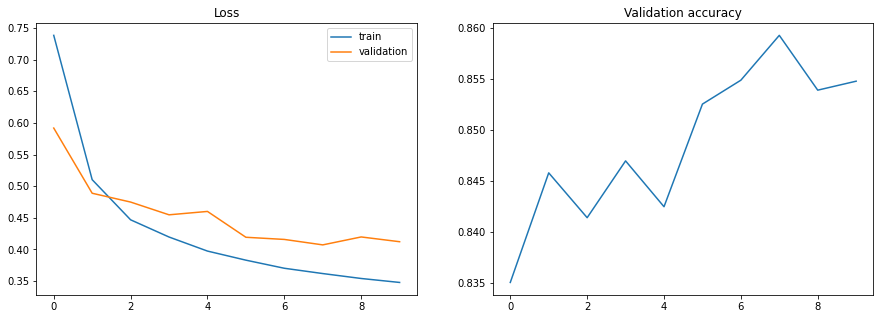

In [117]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [124]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 14*14),
            nn.LeakyReLU(),
            nn.Linear(14*14, 7*7),
            nn.Softplus(),
            nn.Linear(7*7, num_classes),
            nn.Tanh()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

    def __call__(self, inp):
      return self.forward(inp)

In [125]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 196]         153,860
         LeakyReLU-3                  [-1, 196]               0
            Linear-4                   [-1, 49]           9,653
          Softplus-5                   [-1, 49]               0
            Linear-6                   [-1, 10]             500
              Tanh-7                   [-1, 10]               0
Total params: 164,013
Trainable params: 164,013
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.63
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


In [131]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader,
                                                 test_loader, loss_func,
                                                 opt, n_epochs)

Epoch 1 of 30 took 6.050s
	  training loss: 1.189639
	validation loss: 1.095311
	validation accuracy: 0.784
Epoch 2 of 30 took 6.077s
	  training loss: 1.046796
	validation loss: 1.043930
	validation accuracy: 0.831
Epoch 3 of 30 took 5.892s
	  training loss: 1.007942
	validation loss: 1.014209
	validation accuracy: 0.849
Epoch 4 of 30 took 5.828s
	  training loss: 0.994082
	validation loss: 1.006085
	validation accuracy: 0.852
Epoch 5 of 30 took 5.875s
	  training loss: 0.982943
	validation loss: 0.999299
	validation accuracy: 0.853
Epoch 6 of 30 took 5.888s
	  training loss: 0.973645
	validation loss: 1.010612
	validation accuracy: 0.841
Epoch 7 of 30 took 5.938s
	  training loss: 0.967330
	validation loss: 0.992831
	validation accuracy: 0.865
Epoch 8 of 30 took 5.934s
	  training loss: 0.960362
	validation loss: 0.987025
	validation accuracy: 0.870
Epoch 9 of 30 took 5.868s
	  training loss: 0.956821
	validation loss: 0.986359
	validation accuracy: 0.867
Epoch 10 of 30 took 5.978s
	

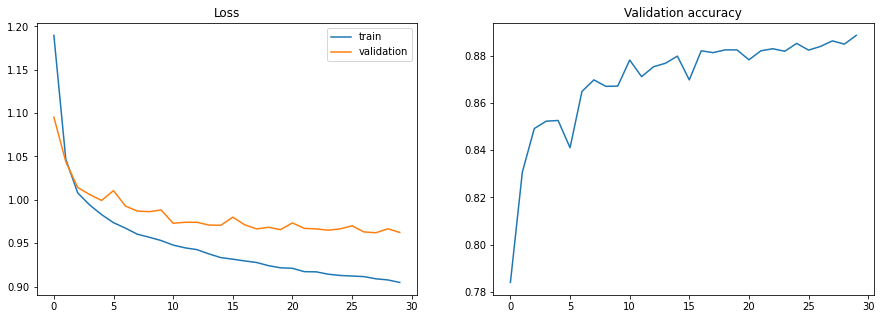

In [132]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [137]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 14*14),
            nn.LeakyReLU(),
            nn.BatchNorm1d(14*14),
            nn.Linear(14*14, 7*7),
            nn.Dropout(),
            nn.Softplus(),
            nn.Linear(7*7, num_classes),
            nn.Tanh()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

    def __call__(self, inp):
        return self.forward(inp)

In [138]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 196]         153,860
         LeakyReLU-3                  [-1, 196]               0
       BatchNorm1d-4                  [-1, 196]             392
            Linear-5                   [-1, 49]           9,653
           Dropout-6                   [-1, 49]               0
          Softplus-7                   [-1, 49]               0
            Linear-8                   [-1, 10]             500
              Tanh-9                   [-1, 10]               0
Total params: 164,405
Trainable params: 164,405
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.63
Estimated Total Size (MB): 0.64
-------------------------------------------

In [139]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

n_epochs = 30
train_loss, val_loss, val_accuracy = train_model(model, train_loader,
                                                 test_loader, loss_func,
                                                 opt, n_epochs)

Epoch 1 of 30 took 6.177s
	  training loss: 1.160049
	validation loss: 1.031758
	validation accuracy: 0.843
Epoch 2 of 30 took 6.124s
	  training loss: 1.048887
	validation loss: 1.021852
	validation accuracy: 0.842
Epoch 3 of 30 took 6.023s
	  training loss: 1.030172
	validation loss: 1.017705
	validation accuracy: 0.853
Epoch 4 of 30 took 6.053s
	  training loss: 1.018025
	validation loss: 1.005366
	validation accuracy: 0.860
Epoch 5 of 30 took 6.055s
	  training loss: 1.009655
	validation loss: 1.002306
	validation accuracy: 0.853
Epoch 6 of 30 took 5.997s
	  training loss: 1.008482
	validation loss: 1.000434
	validation accuracy: 0.856
Epoch 7 of 30 took 5.980s
	  training loss: 1.002152
	validation loss: 1.014556
	validation accuracy: 0.847
Epoch 8 of 30 took 5.953s
	  training loss: 0.998368
	validation loss: 0.995514
	validation accuracy: 0.862
Epoch 9 of 30 took 5.939s
	  training loss: 0.994007
	validation loss: 0.996437
	validation accuracy: 0.859
Epoch 10 of 30 took 6.000s
	

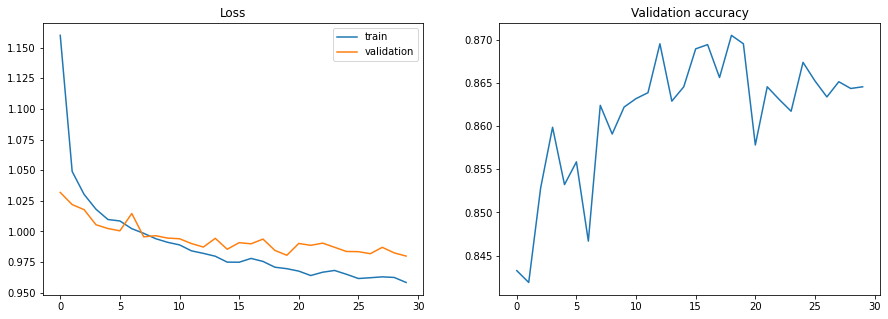

In [140]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._

- Переобучиться получилось достаточно легко, если не добавлять dropout/batchnorm слои. Видим на train/validation plot'e для переобученной модели с какого-то момента validation loss перестает падать, в то время как loss на train'e продолжает уменьшаться. Это сигнал о том, что модель начала запоминать train выборку

- Добавление batchnorm'a после первой функции активации и dropout'a после предпоследнего линейного слоя улучшило ситуацию с переобучением, на train/val loss plot'e видно, что обе кривые убывают. Также добавление dropouta'a ожидаемо уменьшило скор на тесте, тк сложность моедли падает с добавлением dropout'a

- При сравнении tran/val loss'a моделей, можно заметить что добавление batchnorm'a ожидаемо улучшает сходимость.